In [1]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 3.3MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [0]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

In [4]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompletePATYRP/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [9]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2, activation= 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model

In [10]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 751s 1s/step - loss: 0.3387 - accuracy: 0.9774 - val_loss: 0.3257 - val_accuracy: 0.9886
Epoch 2/3
582/582 [==============================] - 733s 1s/step - loss: 0.3246 - accuracy: 0.9898 - val_loss: 0.3238 - val_accuracy: 0.9910
Epoch 3/3
582/582 [==============================] - 733s 1s/step - loss: 0.3227 - accuracy: 0.9910 - val_loss: 0.3237 - val_accuracy: 0.9890


#Check the predictions

In [11]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [12]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog',
       'cat', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [13]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0]
Predicted labels:  [0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0]


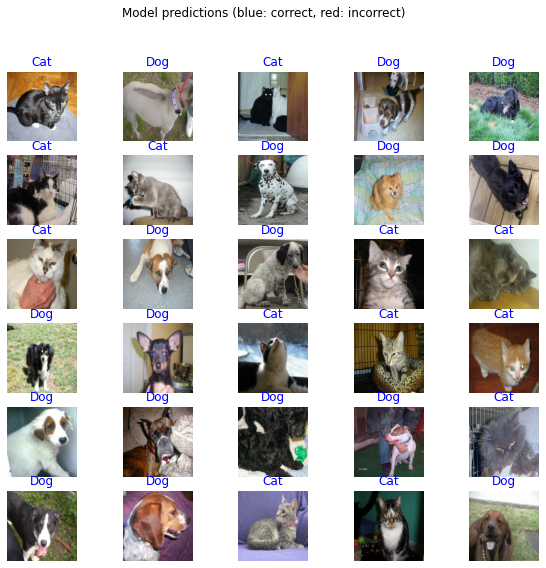

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

#Part 3: Save as Keras .h5 model

In [15]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1591205053.h5


In [16]:
!ls

1591205053.h5  sample_data


# Part 4: Load the Keras .h5 Model

In [17]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [22]:
(abs(result_batch- reloaded_result_batch)).max()

0.0

In [23]:
EPOCHS = 3
history = reloaded.fit(train_batches,
                       epochs= EPOCHS,
                       validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 736s 1s/step - loss: 0.3214 - accuracy: 0.9925 - val_loss: 0.3229 - val_accuracy: 0.9903
Epoch 2/3
582/582 [==============================] - 739s 1s/step - loss: 0.3205 - accuracy: 0.9935 - val_loss: 0.3229 - val_accuracy: 0.9895
Epoch 3/3
582/582 [==============================] - 750s 1s/step - loss: 0.3197 - accuracy: 0.9947 - val_loss: 0.3246 - val_accuracy: 0.9880


#Part 5: Export as SavedModel

In [24]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1591207665
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1591207665/assets


INFO:tensorflow:Assets written to: ./1591207665/assets


In [25]:
!ls {export_path_sm}

assets	saved_model.pb	variables


# Part 6: Load SavedModel

In [0]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [0]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

In [28]:
(abs(result_batch - reload_sm_result_batch)).max()

0.0

# Part 7: Loading the SavedModel as a Keras Model

In [29]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1591207699
INFO:tensorflow:Assets written to: ./1591207699/assets


INFO:tensorflow:Assets written to: ./1591207699/assets


In [30]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

In [32]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

# Part 8: Download your model

In [33]:
!zip -r model.zip {export_path_sm}

  adding: 1591207699/ (stored 0%)
  adding: 1591207699/variables/ (stored 0%)
  adding: 1591207699/variables/variables.index (deflated 78%)
  adding: 1591207699/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1591207699/assets/ (stored 0%)
  adding: 1591207699/saved_model.pb (deflated 92%)


In [34]:
!ls

1591205053.h5  1591207665  1591207699  model.zip  sample_data


In [0]:
# to download the zip

try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass